In [2]:
import os
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from tkinter import filedialog as fd

In [3]:
class MZI:
    def __init__(self, col, row, leng = 0, fsr=0, fsr_idep=0):
        self.col = col
        self.row = row
        self.leng = leng
        self.fsr = fsr
        self.fsr_idep = fsr_idep
        self.wvl_idep = []
        self.vol_idep = []
        

    def printDetails(self):
            print(f"Device: ({self.col},{self.row}) \n PCM length: {self.leng} um \n FSR Before PCM Deposition: {self.fsr} \n FSR After PCM Deposition (Crystalline): {self.fsr_idep}")

In [4]:
# CREATE AN ARRAY OF BLANK MZIs MATCHING CHIP CONFIGURATION ##########################################################

def makeMZIarray():
    MZI_arr = []
    for i in range(36):
        col = i//12+1
        row = i%12+1
        if col == 3:
            leng = 15
        else:
            leng = round(15 - (i-(i//12*12))*1.1,1)
            if (row) == 12:
                leng = 0
        MZI_arr.append(MZI(col,row, leng))
    return(MZI_arr)

    # for i in range(len(MZI_arr)):
    #     MZI_arr[i].printDetails()

In [5]:
MZI_arr = makeMZIarray()

In [70]:
def addData(folderpath,num):
    plt.rcParams['agg.path.chunksize'] = 10000 #prevents matplot crash if there are too many data points

    # #Popup Menu to select File
    # root = tk.Tk()
    # root.withdraw()  
    # folderpath = fd.askdirectory()
        
    #process all the files in the folder
    for filename in os.listdir(folderpath):
        if not filename.startswith('.') and os.path.isfile(os.path.join(folderpath, filename)):
            filepath = os.path.join(folderpath, filename)
            # print(filepath)
            wavelength = []
            voltage = []

            with open(filepath, 'r', encoding="utf-8", errors="ignore") as file:
                for line in file:
                    data = line.strip().split('\t')
                    wavelength.append(data[0])
                    if len(data) > 1:  # Ensure there are at least two elements
                        voltage.append(data[1])
                    else:
                        print(f"Skipping line due to insufficient data: ")
                        print(line)
            
            #Wavelength x-axis, Voltage y-axis
            wavelength_array = np.array(wavelength, dtype='float64')
            voltage_array = np.array(voltage, dtype='float64')
            
            #find the Maxima of the graph
            distance = 85000
            maxima, _ = signal.find_peaks(voltage_array, distance=distance)
            np.diff(maxima)
            avg_wave=0
            divisions = len(maxima)
            wave = wavelength_array[maxima]

            #Average FSR
            for i in range(1,len(wave)-1):
                avg_wave +=  wave[i] - wave[i-1]
            if(divisions>0):
                avg_wave = avg_wave/divisions

            col = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[0])
            row = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[1:])

            key = (col-1)*12 + (row-1)


            if num == 1:
                MZI_arr[key].fsr = avg_wave
            elif num == 2:
                MZI_arr[key].fsr_idep = avg_wave
                MZI_arr[key].wvl_idep = wavelength_array
                MZI_arr[key].vol_idep = voltage_array
            else:
                print('incorrect KEY')
                exit


def plotData(col,row, num, save = False):

    key = (col-1)*12 + (row-1)

    voltage_array = []
    wavelength_array = []
    name = ""

    if num == 1:
        voltage_array = MZI_arr[key].vol
        wavelength_array = MZI_arr[key].wvl
        fsr = MZI_arr[key].fsr
        name = "Before PCM Deposition"
    elif num == 2:
        voltage_array = MZI_arr[key].vol_idep
        wavelength_array = MZI_arr[key].wvl_idep
        fsr = MZI_arr[key].fsr_idep
        name = "After PCM Deposition (Crystalline)"
    else:
        print('incorrect KEY')
        exit


    min_voltage = np.min(voltage_array)
    max_voltage = np.max(voltage_array)


    #find the Maxima of the graph
    distance = 85000
    maxima, _ = signal.find_peaks(voltage_array, distance=distance)
    minima, _ = signal.find_peaks(-voltage_array, distance=distance)


    minmax = np.concatenate((maxima, minima))
    minmax.sort()


    
    np.diff(maxima)


    #Graph Setup
    plt.figure(figsize=(12, 8))
    plt.title(f"Device ({col},{row}) - {name}")
    plt.xticks(np.arange(wavelength_array[0]-10, wavelength_array[-1]+10, 5.0))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Voltage (a.u.)")


    plt.plot(wavelength_array,voltage_array)
    plt.figtext(0.5,0.95, f"Average FSR: {fsr:.3f}", horizontalalignment='center')

    plt.vlines(wavelength_array[maxima],min_voltage,max_voltage,linestyles="dashed",colors="lightblue")
    
    plt.plot(wavelength_array[maxima],voltage_array[maxima],"x")

    for points in maxima:
        plt.annotate(f"{wavelength_array[points]:.5f}", (wavelength_array[points],voltage_array[points]))

    # plt.plot(wavelength_array[minima],voltage_array[minima],"x")

    # plt.plot(wavelength_array[minmax],voltage_array[minmax],"x")


    minmax_short = []
    mid = len(minmax)//2 #good
    print(f"mid: {mid}") #good
    print(f"mid vol: {voltage_array[minmax[mid]]}") #good
    print(f"mid wvl: {wavelength_array[minmax[mid]]}") #good

    ext = [] # extinction ratio
    num_points = 6 # only do even numbers for now
    if (voltage_array[minmax[mid]] < voltage_array[minmax[mid+1]]):
        minmax_short = minmax[mid-(num_points-1) : mid+num_points+2] 
    else:
        minmax_short = minmax[mid-num_points:mid+num_points+1]

    for i in range(num_points):
        ext.append(1 - (2*voltage_array[minmax_short[2*i+1]]) / (voltage_array[minmax_short[2*i]] + voltage_array[minmax_short[2*i+2]]))
        print(f"(left {voltage_array[minmax_short[2*i]]} + right {voltage_array[minmax_short[2*i+2]]}) / (2* min {voltage_array[minmax_short[2*i+1]]})")
        print(f"(left {wavelength_array[minmax_short[2*i]]} + right {wavelength_array[minmax_short[2*i+2]]}) / (2* min {wavelength_array[minmax_short[2*i+1]]})")

    for i in range(len(ext)):
        print(ext[i])
    
    j = 0
    for points in range(len(minmax_short)):
        if points%2 == 1:
            x = wavelength_array[minmax_short[points]]
            y = voltage_array[minmax_short[points]]
            plt.annotate(f"Ext: {ext[j]:.3f}", 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, -10),  # 10 points below the peak
                ha='center', 
                va='top',
                fontsize=8)
            # plt.annotate(f"Ext: {ext[j]:.3f}", (wavelength_array[minmax_short[points]],voltage_array[minmax_short[points]]))
            j+=1

    
    # for points in maxima:
    #     max_arr_vol.append(voltage_array[points])
    #     max_arr_wvl.append(wavelength_array[points])
    #     plt.annotate(f"{wavelength_array[points]:.3f}", (wavelength_array[points],voltage_array[points]))

    # for points in minima:
    #     min_arr_vol.append(voltage_array[points])
    #     min_arr_wvl.append(wavelength_array[points])
    #     plt.annotate(f"{wavelength_array[points]:.3f}", (wavelength_array[points],voltage_array[points]))

    # if (save == True):
    #     plt.savefig(f"{folderpath}/plots/{filename.split('.')[0]}.png", dpi=650, bbox_inches="tight")
    #     plt.close()

    plt.show()


In [7]:
MZI_arr = makeMZIarray()
# print(MZI_arr[1].details())

In [8]:
folderpath = '/Users/kamilakunes/Desktop/PhDwork/Phase Change Modulator/ModCAD/PlottingTool/061225PCMiDep'
addData(folderpath, 2) # 2 means add data to second FSR slot which is for iDep. 1 is for before PCM dep

mid: 16
mid vol: 0.02748
mid wvl: 1558.12744
(left 0.26103 + right 0.2993) / (2* min 0.01061)
(left 1533.31536 + right 1543.13624) / (2* min 1538.43008)
(left 0.2993 + right 0.33888) / (2* min 0.01061)
(left 1543.13624 + right 1553.20336) / (2* min 1547.69536)
(left 0.33888 + right 0.39402) / (2* min 0.02748)
(left 1553.20336 + right 1563.39408) / (2* min 1558.12744)
(left 0.39402 + right 0.36126) / (2* min 0.01029)
(left 1563.39408 + right 1573.07944) / (2* min 1568.35592)
(left 0.36126 + right 0.26168) / (2* min 0.02878)
(left 1573.07944 + right 1583.46344) / (2* min 1578.63776)
(left 0.26168 + right 0.30482) / (2* min 0.02067)
(left 1583.46344 + right 1594.54896) / (2* min 1589.64288)
0.9621294594256956
0.966749193017644
0.9250102333196889
0.9727518271369558
0.9075994477798826
0.9270255957634599


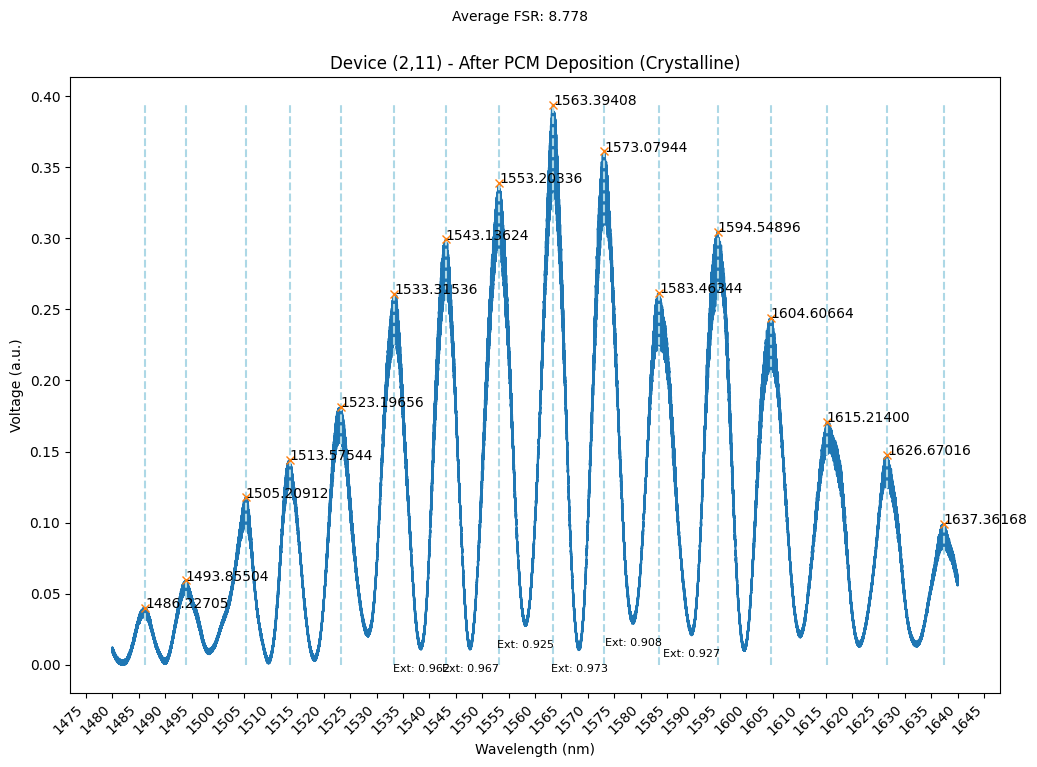

In [71]:
plotData(2,11,2)

In [56]:
print(MZI_arr[1].vol_idep)

[0.00348 0.00315 0.0025  ... 0.04597 0.04532 0.04629]


In [ ]:
for i in range(len(MZI_arr)):
    MZI_arr[i].printDetails()


In [ ]:
string = "PCM_D2 MZI203 20dB atten f2fs iDep"

x = string.split()
print(x)

print(x[1])

res = "".join([ele for ele in x[1] if ele.isdigit()])
print(int(res))

print(string.split()[1])

['PCM_D2', 'MZI203', '20dB', 'atten', 'f2fs', 'iDep']
MZI203
203
MZI203


In [ ]:
filename = "PCM_D2 MZI203 20dB atten f2fs iDep"
col = "".join([ele for ele in filename.split()[1] if ele.isdigit()])[0]
row = "".join([ele for ele in filename.split()[1] if ele.isdigit()])[1:]

print(int(col))
print(int(row))

2
3


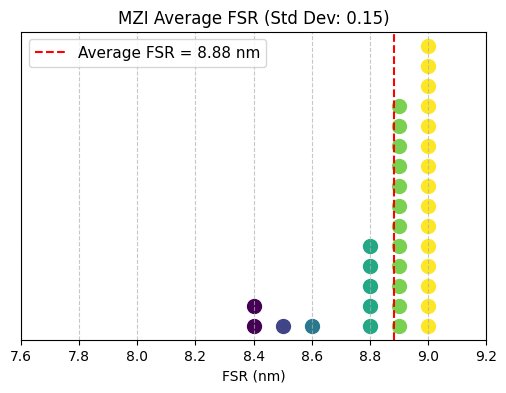

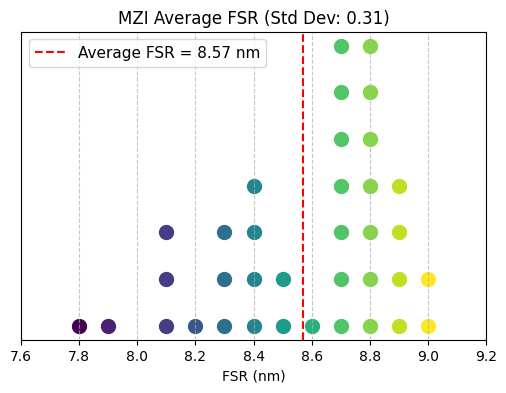

In [ ]:
#Measurement Before PCM Deposition

fsr = [8.82, 8.98, 8.53, 8.93, 8.97, 8.42, 8.39, 8.82, 8.96, 8.95, 9.00, 8.87, 8.92, 8.96, 8.89, 8.99, 8.98, 9.00, 8.59, 9.02, 8.83, 8.82, 8.97, 8.95, 8.94, 8.94, 8.93, 8.93, 9.01, 8.85, 8.94, 8.89, 8.95, 8.93, 8.97, 8.91]
fsr_round = np.round(fsr, decimals=1)
fsr_avg = sum(fsr) / len(fsr)
fsr_std_dev = np.std(fsr, ddof=0)

unique_values, counts = np.unique(fsr_round, return_counts=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

plt.figure(figsize=(6, 4))

for i, (val, count) in enumerate(zip(unique_values, counts)):
    plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

plt.axvline(x=fsr_avg, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg:.2f} nm")
plt.xticks(np.arange(7.6, 9.3, step=0.2))
plt.yticks([])
plt.xlabel("FSR (nm)")
plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev:.2f})")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(fontsize=11)

plt.show()




# Initial Measurement After PCM Deposition

fsr_idep = [8.19, 8.12, 8.68, 7.90, 8.89, 8.83, 8.51, 8.81, 8.71, 9.01, 8.83, 8.80, 8.67, 8.72, 8.70, 8.42, 8.34, 8.20, 8.88, 8.80, 8.13, 8.90, 8.78, 8.98, 8.72, 8.66, 8.43, 8.64, 8.40, 8.94, 8.49, 8.43, 7.78, 8.27, 8.26, 8.79]
fsr_round_idep = np.round(fsr_idep, decimals=1)
fsr_avg_idep = sum(fsr_idep) / len(fsr_idep)
fsr_std_dev_idep = np.std(fsr_idep, ddof=0)

unique_values, counts = np.unique(fsr_round_idep, return_counts=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

plt.figure(figsize=(6, 4))

for i, (val, count) in enumerate(zip(unique_values, counts)):
    plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

plt.axvline(x=fsr_avg_idep, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg_idep:.2f} nm")
plt.xticks(np.arange(7.6, 9.3, step=0.2))
plt.yticks([])
plt.xlabel("FSR (nm)")
plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev_idep:.2f})")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(fontsize=11)

plt.show()

In [ ]:
mzi1 = MZI(1,1,8.8,8.2)

mzi1.details()

Device: (1,1) 
 FSR Before PCM Deposition: 8.8 
 FSR After PCM Deposition (Crystalline): 8.2


In [ ]:
class Dog:
    def __init__(self, name, breed, age):
        self.name = name
        self.breed = breed
        self.age = age

    def bark(self):
        print(f"{self.name} says woof!")

In [ ]:
ruff = Dog('Roop', 'gr', 5)
print (ruff.age)
ruff.bark()


5
Roop says woof!
